# Roll No: 2018101075

# Excercise 1

In the tutorial you saw how to compute LDA for a two class problem. In this excercise we will work on a multi-class problem. We will be working with the famous Iris dataset that has been deposited on the UCI machine learning repository
(https://archive.ics.uci.edu/ml/datasets/Iris).

The iris dataset contains measurements for 150 iris flowers from three different species.

The three classes in the Iris dataset:
1. Iris-setosa (n=50)
2. Iris-versicolor (n=50)
3. Iris-virginica (n=50)

The four features of the Iris dataset:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

<img src="iris_petal_sepal.png">



In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import pi

### Importing the dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
dataset = pd.read_csv(url, names=names)

dataset.tail()

,sepal-length,sepal-width,petal-length,petal-width,Class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


### Data preprocessing

Once dataset is loaded into a pandas data frame object, the first step is to divide dataset into features and corresponding labels and then divide the resultant dataset into training and test sets. The following code divides data into labels and feature set:

In [3]:
X = dataset.iloc[:, 0:4].values
y = dataset.iloc[:, 4].values

The above script assigns the first four columns of the dataset i.e. the feature set to X variable while the values in the fifth column (labels) are assigned to the y variable.

The following code divides data into training and test sets:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Feature Scaling

We will now perform feature scaling as part of data preprocessing too. For this task, we will be using scikit learn `StandardScalar`.

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
print(X_train.shape)
print(y_train.shape)

(120, 4)
(120,)


## Write your code below

Write you code below to LDA on the IRIS dataset and compute the overall accuracy of the classifier.

In [7]:
### WRITE YOUR CODE HERE ####

def getlabel(y, labels=None):
    if labels == None: labels = [i for i in range(y.shape[0])]
    classes = np.unique(y)
    out = np.zeros((y.shape[0]), dtype='object')
    cnt = 0
    for c in classes:
        out[y == c] = labels[cnt]
        cnt += 1
    return out

def cov(X):
    return 1 / X.shape[0] * X.T @ X

def LDA(X_train, y_train):
    
    m, d = X_train.shape
    mean = np.mean(X_train, axis=0).reshape((1, -1))
    SW, SB = np.zeros((d, d)), np.zeros((d, d))
    classes = np.unique(y_train)
    for c in range(classes.shape[0]):
        Xc = X_train[y_train == classes[c]]
        meanc = np.mean(Xc, axis=0).reshape((1, -1))
        SB += Xc.shape[0] * cov(meanc - mean)
        SW += cov(Xc - meanc)
    SB /= m
    
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(SW) @ SB)
    
    idx = np.argsort(eigvals)[::-1]
    eigvals = np.real(eigvals[idx])
    eigvecs = np.real(eigvecs[:, idx])
    
    return eigvecs[:, 0:1].T

In [8]:
W = LDA(X_train, y_train)

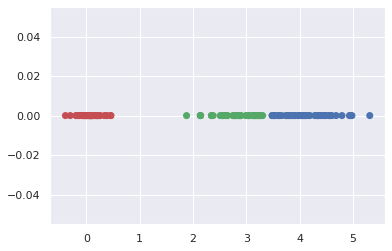

In [9]:
plt.scatter((W @ X.T).ravel(), np.zeros((X.shape[0])), c=getlabel(y,['r', 'g', 'b']))
plt.show()

In [10]:
def init_weights(n_features, n_outputs):
    const = 1 / np.sqrt(n_features)
    W = np.random.randn(n_features, n_outputs) * const
    W[-1, :] = 0
    return W

def cost_fun(Y, Y_pred, epsilon=1e-8):
    Y_pred = np.where(Y == 1, Y_pred, 1 - Y_pred)
    Y_pred = np.where(Y_pred == 0, Y_pred + epsilon, Y_pred)
    cost = -1 / Y.shape[0] * np.sum(np.log(Y_pred))
    return cost

def two_class_data(X_in, y_in, k1, k2):
    idx = np.where((y_in == k1) | (y_in == k2))
    X = X_in[idx]
    Y = y_in[idx]
    Y = np.where(Y == k1, 1, 0).reshape((-1, 1))
    return X, Y

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

def predict_onevsone(X, W):
    X = add_bias(X)
    n_classes = int(np.sqrt(W.shape[1]))
    y_pred = np.where((X @ W) >= 0, 1, 0).reshape((X.shape[0], n_classes, n_classes))
    return np.argmax(np.sum(y_pred, axis=-1), axis=1)

def accuracy_onevsone(X, y, W):
    y_pred = predict_onevsone(X, W)
    return np.count_nonzero(getlabel(y) == y_pred) / y.shape[0]

def predict_onevsall(X, W):
    X = add_bias(X)
    return np.argmax(X @ W, axis = 1)

def accuracy_onevsall(X, y, W):
    y_pred = predict_onevsall(X, W)
    return np.count_nonzero(getlabel(y) == y_pred) / y.shape[0]

def train(X, Y, epochs=10000, lr=0.01):
    n_samples, n_features = X.shape
    W = init_weights(n_features, 1)
    for epoch in range(epochs):
        Y_pred = sigmoid(X @ W)
        gradient = 1 / n_samples * X.T @ (Y - Y_pred)
        W += lr * gradient
        if epoch % (epochs // 5) == 0:
            print(f"Epoch {epoch}: train loss {cost_fun(Y, Y_pred)}")
    return W

def onevsoneClassifier(X_train, y_train, epochs=1000, lr=0.01):
    X_train = add_bias(X_train)
    y_train = getlabel(y_train)
    n_examples, n_features = X_train.shape
    classes = np.unique(y_train)
    
    W = []
    print(f"Training one vs one classifier starts")
    for k1 in classes:
        for k2 in classes:
            print(f"Training {k1} vs {k2} classifier")
            X, Y = two_class_data(X_train, y_train, k1, k2)
            W.append(train(X, Y, epochs, lr).ravel())
    print(f"Training one vs one classifier ends")
    return np.array(W).T

def onevsallClassifier(X_train, y_train, epochs=10000, lr=0.1):
    X_train = add_bias(X_train)
    y_train = getlabel(y_train)
    n_examples, n_features = X_train.shape
    classes = np.unique(y_train)
    
    W = []
    print(f"Training one vs all classifier starts")
    for k in classes:
        print(f"{k} vs all classifier starts")
        W.append(train(X_train, np.where(y_train == k, 1, 0).reshape((-1, 1)), epochs, lr).ravel())
        print(f"{k} vs all classifier ends")
    print(f"Training one vs all classifier ends")
    return np.array(W).T

In [11]:
W_onevsall = onevsallClassifier(X_train @ W.T, y_train, 100000, 2)

Training one vs all classifier starts
0 vs all classifier starts
Epoch 0: train loss 0.4648907540001754
Epoch 20000: train loss 8.131466572101591e-05
Epoch 40000: train loss 4.276186928945999e-05
Epoch 60000: train loss 2.9300189489791646e-05
Epoch 80000: train loss 2.238482854872249e-05
0 vs all classifier ends
1 vs all classifier starts
Epoch 0: train loss 0.8134039775294607
Epoch 20000: train loss 0.6005433149008521
Epoch 40000: train loss 0.6005433149008521
Epoch 60000: train loss 0.6005433149008521
Epoch 80000: train loss 0.6005433149008521
1 vs all classifier ends
2 vs all classifier starts
Epoch 0: train loss 0.45361683696651167
Epoch 20000: train loss 0.05113344220429827
Epoch 40000: train loss 0.05112957948474221
Epoch 60000: train loss 0.05112957150290266
Epoch 80000: train loss 0.05112957148562361
2 vs all classifier ends
Training one vs all classifier ends


In [12]:
print(f"Training accuracy: {accuracy_onevsall(X_train @ W.T, y_train, W_onevsall)}")
print(f"Test accuracy: {accuracy_onevsall(X_test @ W.T, y_test, W_onevsall)}")

Training accuracy: 0.9833333333333333
Test accuracy: 1.0


In [13]:
def plot1D_decision_boundary(X, y):
    X = X.ravel()
    label = np.unique(y)
    fig, ax = plt.subplots()
    ax.scatter(X, np.zeros((X.shape[0])), c=getlabel(y, ['r','g','b']), label=label, marker='x')
    X = np.linspace(-3, 3, 100)
    y = predict_onevsall(X.reshape((-1, 1)), W_onevsall)
    ax.scatter(X, np.zeros((X.shape[0])), alpha=0.3, c=getlabel(y,['r','g','b']), label=label)
    ax.legend()
    plt.show()

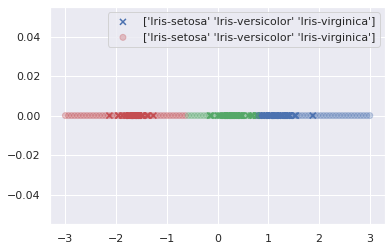

In [14]:
plot1D_decision_boundary(X_train @ W.T, y_train)